# WIRC+Pol Modulation Sequence Tutorial #

This tutorial is to show you how to reduce WIRC+Pol data obtained after March 2019 using the new awesome modulator to obtain q,u,p and theta. 

In this tutorial we assume that you have already been through the two other tutorials, named WIRC+Pol_Tutorial_1-Single_File_Spectral_Extraction and WIRC+Pol_Tutorial_2-Reducing_a_Dataset. These tutorials will touch on installation, give you a good instroduction as to formats of WIRC+Pol data and demonstrate how to extract the spectra for a larger dataset. 

Here we assume that you already have run the pipeline to extract spectra on a dataset, but have yet to combine them via single differencing (in time) or double-differencing. 

In [13]:
import numpy as np
import glob
import wirc_drp.wirc_object as wo
from wirc_drp.utils import source_utils
from wirc_drp.utils import calibration as wc
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings; warnings.simplefilter('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Read in the files - Tutorial Dataset ###

For the purpose of this tutorial, we are providing you with spectra and hwp angles in .np files. That we read in here. Below we show a commented out example of how you would get these same inputs from a WIRC+Pol dataset.

We assume here that the group of spectra have already been aligned (see the Dataset tutorial). 

In [16]:
all_spec_cube = np.load("sample_data/Elia2-14_HWP_Spectra.npy") #The extracted spectra
hwp_ang = np.load("sample_data/Elia2-14_HWP_Angles.npy") #The HWP angles
wvs = all_spec_cube[0,0,0,:] #Grab the wavelengths from the first cube
nfiles = all_spec_cube.shape[0]

### Read in the files - Normal Operations ###

The following three commented out boxes give you an example of how to read in the data for this tutorial from normal wircpol_object fits files. You would do something like this when reducing your own data. 


In [3]:
### Read in the files. 
#fnames = np.sort(glob.glob("/path_to_your_files_here/*.fits"))
#nfiles = len(fnames)
#print("Found {} files".format(nfiles))

In [4]:
### Read in the first one to get the spectra size
#test= wo.wirc_data(wirc_object_filename=fnames[0],verbose=False)

### Create a list to read the spectra into
# all_spec_cube = []

### And the HWP angles
#hwp_ang = np.zeros([nfiles])
#time = np.zeros([nfiles])

In [5]:
# all_spec_cube = []
# for im in np.arange(nfiles):
#     wirc_object = wo.wirc_data(wirc_object_filename=fnames[im],verbose=False)
#     wirc_object.source_list[0].get_broadband_polarization(mode="aperture_photometry")
#     hwp_ang[im] = wirc_object.header['HWP_ANG']
    
#     #Shift the spectra to the side because of the filter tilt. 
#     #The value of -3 used here might not be ideal, but we'll see. 
#     spectra[im,1,:] = np.roll(spectra[im,1,:],-3)
#     spectra[im,3,:] = np.roll(spectra[im,3,:],-3)
    
#     wirc_object.source_list[0].trace_spectra[1,1,:] = np.roll(wirc_object.source_list[0].trace_spectra[1,1,:],-3)
#     wirc_object.source_list[0].trace_spectra[3,1,:] = np.roll(wirc_object.source_list[0].trace_spectra[3,1,:],-3)
    
#     all_spec_cube.append(wirc_object.source_list[0].trace_spectra)

# all_spec_cube = np.array(all_spec_cube)

## Plot the spectra and make sure they're aligned and ready to go

(-2000, 30000)

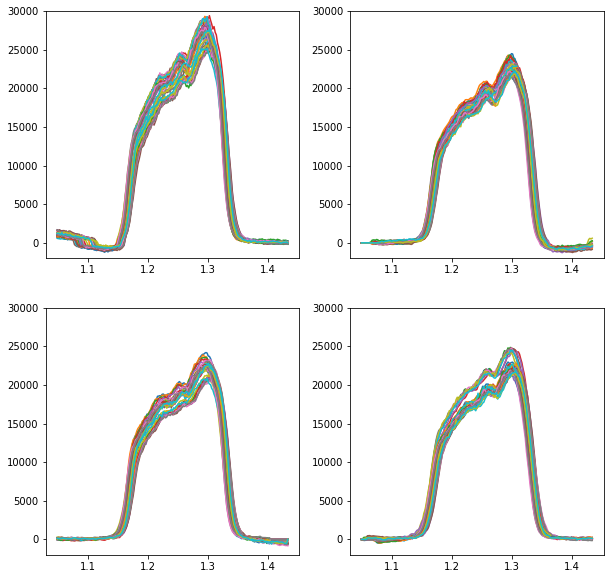

In [17]:
fig,axes = plt.subplots(2,2,figsize=(10,10))

for im in np.arange(nfiles):
    axes[0,0].plot(wvs,all_spec_cube[im,0,1,:])
    axes[0,1].plot(wvs,all_spec_cube[im,1,1,:])
    axes[1,0].plot(wvs,all_spec_cube[im,2,1,:])
    axes[1,1].plot(wvs,all_spec_cube[im,3,1,:])

axes[0,0].set_ylim(-2000,30000)
axes[0,1].set_ylim(-2000,30000)
axes[1,0].set_ylim(-2000,30000)
axes[1,1].set_ylim(-2000,30000)

Things look good here, so let's move on. If the spectra aren't aligned, then go back to the last tutorial and remind yourself how to align a spectral cube. 

## Calculate _q_ and _u_ using single differencing in time for each trace. 

Here we create an array of _q_ and _u_ by using the "Flux Ratio" method". The following function automatically sorts the input data based on the HWP angles that you pass to it and subtracts the appropriate spectra from each other (i.e. 45 degrees from 0 degrees, and 67.5 degrees from 22.5 degrees).

In [7]:
q,u,q_err,u_err,q_ind,u_ind = source_utils.compute_qu_for_obs_sequence(all_spec_cube,hwp_ang,run_alignment=True, method='flux_ratio')

The _q_ and _u_ arrays that are output contain the _q_ and _u_ measurements for each pair of HWP positions. Recall that WIRC+Pol obtains a measurement of both _q_ and _u_ for a given pair of HWP positions. 
The dimensions of the _q_ and _u_ (also q_err and u_err) are [n_measurements/2, wavelength]. To know HWP position a given _q_ or _u_ measurement was made, you can look at the q_ind parameter. 

In [10]:
print(q_ind)

[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]


### Now calculate _p_ and _$\theta$_

In [19]:
p = np.sqrt(q**2+u**2)
theta = 0.5*np.degrees(np.arctan2(u,q))
theta[theta<0] += 180

### Now we can plot our results

Text(0.5, 0, 'Wavelength [$\\mu m$]')

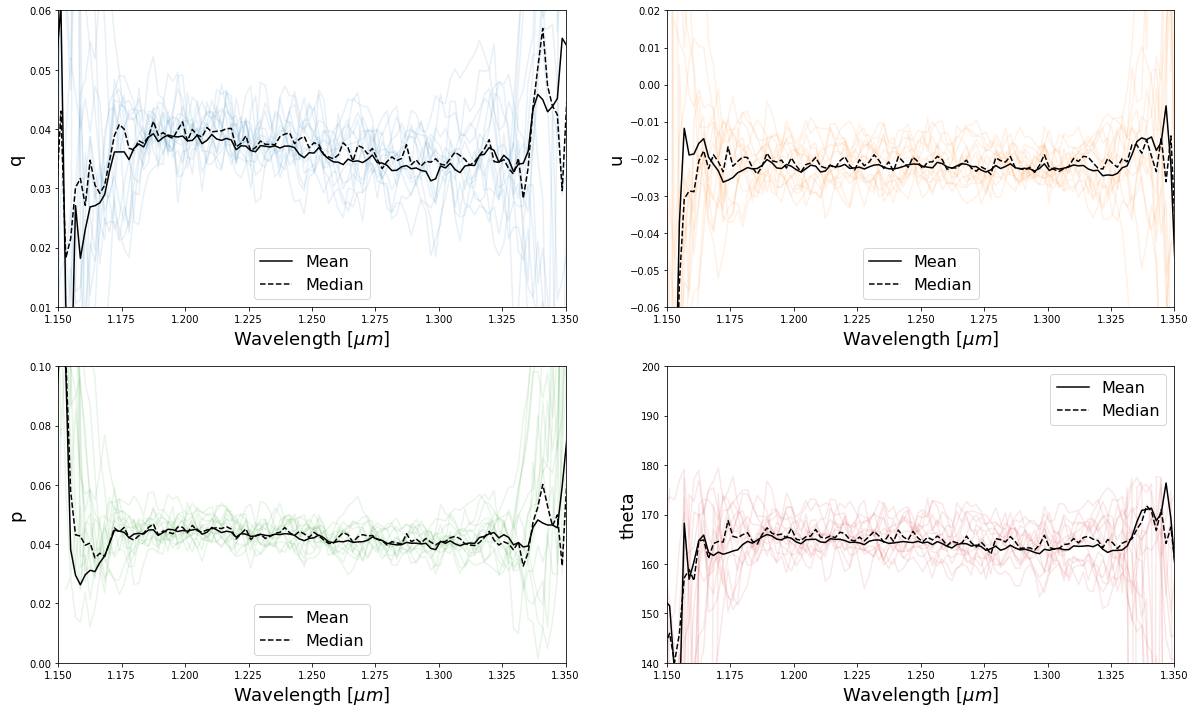

In [31]:
fig,axes = plt.subplots(2,2,figsize=(20,12))

n_q = q.shape[0]

q_mean = np.nanmean(q[:,:],axis=(0))
u_mean = np.nanmean(u[:,:],axis=(0))
q_mean_err = np.sqrt(np.nanmean(q_err))

p_mean = np.sqrt(q_mean**2+u_mean**2)
theta_mean = 0.5*np.degrees(np.arctan2(u_mean,q_mean))
theta_mean[theta_mean<0] += 180


q_median = np.nanmedian(q[:,:],axis=(0))
u_median = np.nanmedian(u[:,:],axis=(0))
p_median = np.sqrt(q_median**2+u_median**2)
theta_median = 0.5*np.degrees(np.arctan2(u_median,q_median))
theta_median[theta_median<0] += 180

for i in range(15):
    #Plot Q
    axes[0,0].plot(wvs,q[i,:], 'C0', alpha=2/n_q)
    
    #Plot U
    axes[0,1].plot(wvs,u[i,:], 'C1', alpha=2/n_q)
    
    #Plot p
    axes[1,0].plot(wvs,p[i,:], 'C2', alpha=2/n_q)

    #Plot theta
    axes[1,1].plot(wvs,theta[i,:], 'C3', alpha=2/n_q)

axes[0,0].plot(wvs,q_mean,'k',label="Mean")    
axes[0,1].plot(wvs,u_mean,'k',label="Mean")   
axes[1,0].plot(wvs,p_mean,'k',label="Mean")
axes[1,1].plot(wvs,theta_mean,'k', label='Mean')

axes[0,0].plot(wvs,q_median,'k--',label="Median")    
axes[0,1].plot(wvs,u_median,'k--',label="Median")    
axes[1,0].plot(wvs,p_median,'k--',label="Median")    
axes[1,1].plot(wvs,theta_median,'k--',label="Median")

axes[0,0].legend(fontsize=16)
axes[0,1].legend(fontsize=16)
axes[1,0].legend(fontsize=16)
axes[1,1].legend(fontsize=16)

axes[0,0].set_xlim(1.15,1.35)
axes[0,1].set_xlim(1.15,1.35)
axes[1,0].set_xlim(1.15,1.35)
axes[1,1].set_xlim(1.15,1.35)

axes[0,0].set_ylim(0.01,0.06)
axes[0,1].set_ylim(-0.06,0.02)
axes[1,0].set_ylim(0,0.1)
axes[1,1].set_ylim(140,200)

axes[0,0].set_ylabel("q",fontsize=18)
axes[0,1].set_ylabel("u",fontsize=18)
axes[1,0].set_ylabel("p",fontsize=18)
axes[1,1].set_ylabel("theta",fontsize=18)


axes[0,0].set_xlabel(r"Wavelength [$\mu m$]",fontsize=18)
axes[0,1].set_xlabel(r"Wavelength [$\mu m$]",fontsize=18)
axes[1,0].set_xlabel(r"Wavelength [$\mu m$]",fontsize=18)
axes[1,1].set_xlabel(r"Wavelength [$\mu m$]",fontsize=18)

Before using this data, we want to apply our instrument calibration that accounts for non-ideal polarimetric efficiencies and crosstalks. The details of how this correction was determined will be published in an upcoming paper. 

The correction was calculated by treating each trace pair (i.e. [top left,bottom right] and [top right,bottom left]) as independent polarimeters, so we first need to split them up to do the correction.  

In [45]:
#Well apply the correction only to the mean values. 

#For the first trace pair
q_mean0 = np.nanmean(q[q_ind==0],axis=(0))
u_mean0 = np.nanmean(u[u_ind==0],axis=(0))
q_mean_err0 = np.sqrt(np.nanmean(q_err[q_ind==0]**2,axis=0))
u_mean_err0 = np.sqrt(np.nanmean(u_err[u_ind==0]**2,axis=0))

p_mean0 = np.sqrt(q_mean0**2+u_mean0**2)
theta_mean0 = 0.5*np.degrees(np.arctan2(u_mean0,q_mean0))
theta_mean0[theta_mean0 < 10] += 180

#For the second trace pair
q_mean1 = np.nanmean(q[q_ind==1],axis=(0))
u_mean1 = np.nanmean(u[u_ind==1],axis=(0))
q_mean_err1 = np.sqrt(np.nanmean(q_err[q_ind==1]**2,axis=0))
u_mean_err1 = np.sqrt(np.nanmean(u_err[u_ind==1]**2,axis=0))

p_mean1 = np.sqrt(q_mean1**2+u_mean1**2)
theta_mean1 = 0.5*np.degrees(np.arctan2(u_mean1,q_mean0))
theta_mean1[theta_mean1 < 10] += 180


#We'll just apply it to the mean q and u
q_cal0,u_cal0,q_err0,u_err0 = wc.calibrate_qu(wvs,q_mean0,u_mean0,q_mean_err0,u_mean_err0,0)
q_cal1,u_cal1,q_err1,u_err1 = wc.calibrate_qu(wvs,q_mean1,u_mean1,q_mean_err1,u_mean_err1,1)

p_cal0 = np.sqrt(q_cal0**2+u_cal0**2)
theta_cal0 = 0.5*np.degrees(np.arctan2(u_cal0,q_cal0))
theta_cal0[theta_cal0<10] += 180

p_cal1 = np.sqrt(q_cal1**2+u_cal1**2)
theta_cal1 = 0.5*np.degrees(np.arctan2(u_cal1,q_cal1))
theta_cal1[theta_cal1<10] += 180

Now let's compare the before and after and include the expected polarization.

Text(0.5, 0, 'Wavelength [$\\mu m$]')

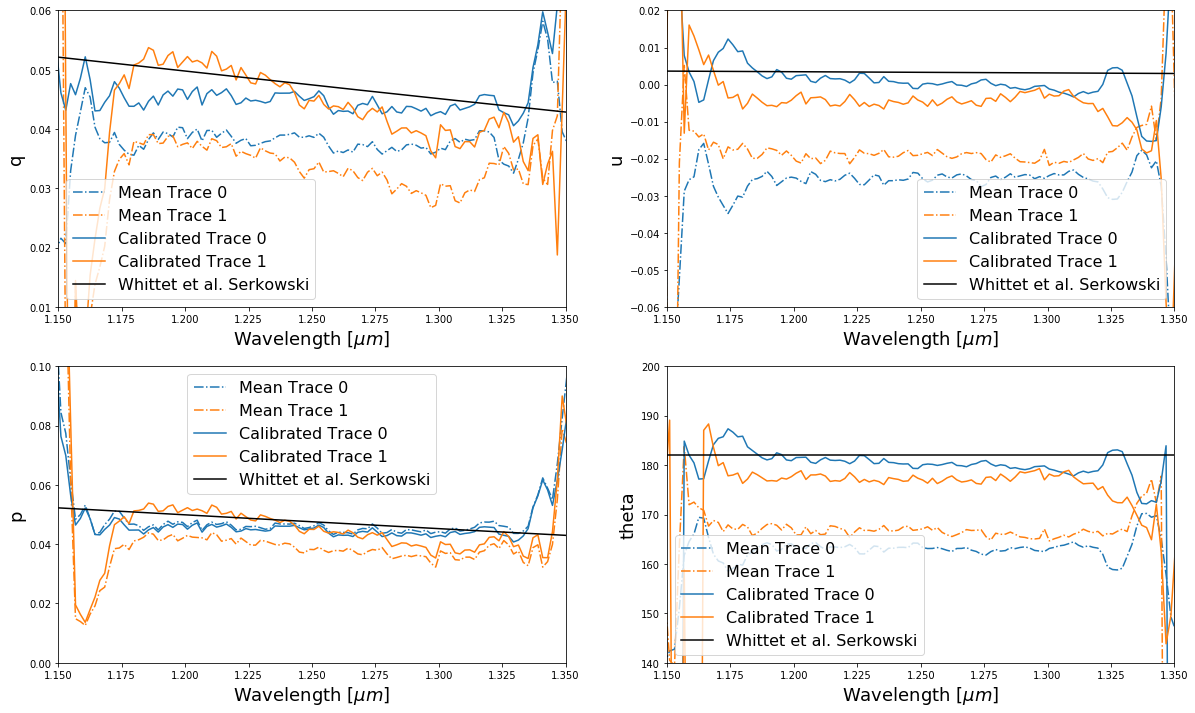

In [49]:
#Get the Serkowski law for Elias 2-14

p_elias,q_elias,u_elias = source_utils.serkowski_polarization(wvs,0.74,0.0656,1.17,theta=182)


fig,axes = plt.subplots(2,2,figsize=(20,12))

axes[0,0].plot(wvs,q_mean0,'-.',label="Mean Trace 0")    
axes[0,1].plot(wvs,u_mean0,'-.',label="Mean Trace 0")   
axes[1,0].plot(wvs,p_mean0,'-.',label="Mean Trace 0")
axes[1,1].plot(wvs,theta_mean0,'-.', label='Mean Trace 0')

axes[0,0].plot(wvs,q_mean1,'-.',label="Mean Trace 1")    
axes[0,1].plot(wvs,u_mean1,'-.',label="Mean Trace 1")   
axes[1,0].plot(wvs,p_mean1,'-.',label="Mean Trace 1")
axes[1,1].plot(wvs,theta_mean1,'-.', label='Mean Trace 1')

axes[0,0].plot(wvs,q_cal0,'C0',label="Calibrated Trace 0")    
axes[0,1].plot(wvs,u_cal0,'C0',label="Calibrated Trace 0")    
axes[1,0].plot(wvs,p_cal0,'C0',label="Calibrated Trace 0")    
axes[1,1].plot(wvs,theta_cal0,'C0',label="Calibrated Trace 0")

axes[0,0].plot(wvs,q_cal1,'C1',label="Calibrated Trace 1")    
axes[0,1].plot(wvs,u_cal1,'C1',label="Calibrated Trace 1")    
axes[1,0].plot(wvs,p_cal1,'C1',label="Calibrated Trace 1")    
axes[1,1].plot(wvs,theta_cal1,'C1',label="Calibrated Trace 1")

axes[0,0].plot(wvs,q_elias,'k',label="Whittet et al. Serkowski")
axes[0,1].plot(wvs,u_elias,'k',label="Whittet et al. Serkowski")
axes[1,0].plot(wvs,p_elias,'k',label="Whittet et al. Serkowski")
axes[1,1].plot(wvs,wvs*0+182,'k',label="Whittet et al. Serkowski")



axes[0,0].legend(fontsize=16)
axes[0,1].legend(fontsize=16)
axes[1,0].legend(fontsize=16)
axes[1,1].legend(fontsize=16)

axes[0,0].set_xlim(1.15,1.35)
axes[0,1].set_xlim(1.15,1.35)
axes[1,0].set_xlim(1.15,1.35)
axes[1,1].set_xlim(1.15,1.35)

axes[0,0].set_ylim(0.01,0.06)
axes[0,1].set_ylim(-0.06,0.02)
axes[1,0].set_ylim(0,0.1)
axes[1,1].set_ylim(140,200)

axes[0,0].set_ylabel("q",fontsize=18)
axes[0,1].set_ylabel("u",fontsize=18)
axes[1,0].set_ylabel("p",fontsize=18)
axes[1,1].set_ylabel("theta",fontsize=18)


axes[0,0].set_xlabel(r"Wavelength [$\mu m$]",fontsize=18)
axes[0,1].set_xlabel(r"Wavelength [$\mu m$]",fontsize=18)
axes[1,0].set_xlabel(r"Wavelength [$\mu m$]",fontsize=18)
axes[1,1].set_xlabel(r"Wavelength [$\mu m$]",fontsize=18)

With this dataset we're not exactly matching as well as we should be to the Whittet et al values, but we're much closer! The mismatch is probably related to the background subtraction used to extract the data. Indeed we can see above when we look at the spectra that it isn't perfect. Something for us to update later! 

Nonetheless, now you should have some great q and u data to try and do science with! Congrats!